<a href="https://colab.research.google.com/github/ALEXASWA/ALEXASWA/blob/main/Image_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow==2.12.0
!pip install keras==2.12.0
!pip install segmentation-models --upgrade
!pip install segmentation-models --upgrade
!pip install patchify

#!pip install tensorflow==2.17



In [4]:
!ls -lah '/content/drive/MyDrive/DubaiDataset'


total 33K
-rw------- 1 root root  548 Feb  6 17:16  classes.json
drwx------ 2 root root 4.0K Feb  6 17:26 'Tile 1'
drwx------ 2 root root 4.0K Feb  6 17:26 'Tile 2'
drwx------ 2 root root 4.0K Feb  6 17:26 'Tile 3'
drwx------ 2 root root 4.0K Feb  6 17:26 'Tile 4'
drwx------ 2 root root 4.0K Feb  6 17:26 'Tile 5'
drwx------ 2 root root 4.0K Feb  6 17:26 'Tile 6'
drwx------ 2 root root 4.0K Feb  6 17:26 'Tile 7'
drwx------ 2 root root 4.0K Feb  6 17:26 'Tile 8'


In [5]:
import os
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import patchify
from patchify import patchify,unpatchify
from sklearn.preprocessing import MinMaxScaler , StandardScaler
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

#deep learning part
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization
from keras.layers import concatenate,BatchNormalization,Dropout, Lambda

#special library imports

import os
os.environ['SM_FRAMEWORK'] = 'tf.keras'  # Use tf.keras backend
import segmentation_models as sm

In [6]:
minmaxscaler=MinMaxScaler()

In [7]:
data_root = '/content/drive/MyDrive/'


In [8]:
data_name='DubaiDataset'

In [ ]:
for path,subdirs,files in os.walk(os.path.join(data_root,data_name)) :
    dir_name=path.split(os.path.sep)[-1]
    print(dir_name)
    images=os.listdir(path)
    for i,image_name in enumerate(images):
      if (image_name.endswith('.jpg')):
          print(image_name)





In [10]:
image_dataset=[]
mask_dataset=[]
for image_type in ['masks','images']:
  if image_type=='masks':
    image_extention='png'
  elif image_type=='images':
      image_extention='jpg'

  for tile_id in range(1,8):
    for image_id in range(1,200):
      image=cv2.imread(f'{data_root}/{data_name}/Tile {tile_id}/{image_type}/image_part_00{image_id}.{image_extention}',1)

      if image is not None:
        if image_type=='masks':
          image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        #print(image.shape)
        #print(image.size)
        patch_size=256
        size_x=(image.shape[1]//patch_size)*patch_size
        size_y=(image.shape[0]//patch_size)*patch_size
      # print('{} ---{} -{}'.format(image.shape,size_x,size_y))
        image=Image.fromarray(image)
        image=image.crop((0,0,size_x,size_y))
        #patchify the image
        image=np.array(image)
        patched_image=patchify(image,(patch_size,patch_size,3),step=patch_size)
        #print(len(patched_image))
        for i in range(patched_image.shape[0]):
          for j in range(patched_image.shape[1]):

             if image_type=='images':
                single_patch_image=patched_image[i,j,:,:]
            #print(single_patch_image.shape)
                single_patch_image=minmaxscaler.fit_transform(single_patch_image.reshape(-1,single_patch_image.shape[-1])).reshape(single_patch_image.shape)
                single_patch_image=single_patch_image[0]
          # print(single_patch_image.shape)
                image_dataset.append(single_patch_image)
             elif image_type=='masks':
                 single_patch_mask=patched_image[i,j,:,:]
                 single_patch_mask=single_patch_mask[0]
            #print(single_patch_image.shape)
                 mask_dataset.append(single_patch_mask)








In [11]:
print(len(image_dataset))
print(len(mask_dataset))

945
945


In [12]:
mask_dataset=np.array(mask_dataset)
image_dataset=np.array(image_dataset)

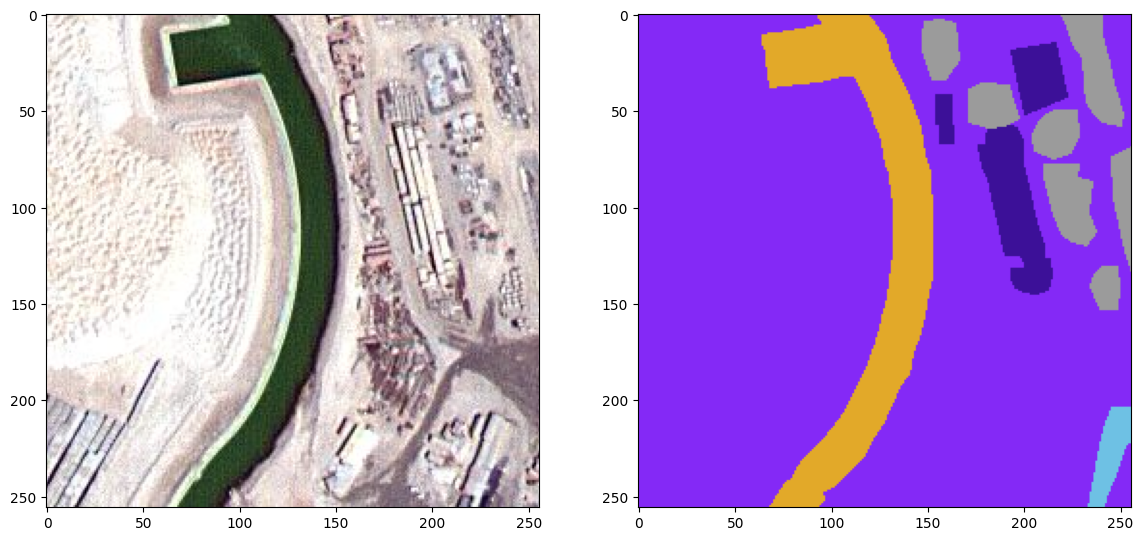

In [13]:
#plots
plt.figure(figsize=(14,7))
plt.subplot(121)
plt.imshow(image_dataset[0])
plt.subplot(122)
plt.imshow(mask_dataset[0])

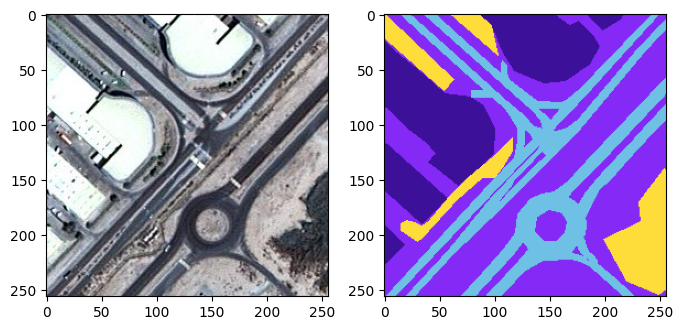

In [77]:
#random plots
random_image=random.randint(0,len(image_dataset))
plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(image_dataset[random_image])
plt.subplot(122)
plt.imshow(mask_dataset[random_image])

In [15]:
#image class conversion into RGB from hexadecimal numbers
class_building='#3C1098'
class_building=class_building.lstrip('#')
class_building=np.array(tuple(int(class_building[i:i+2],16) for i in (0,2,4)))
class_building

class_land='#8429f6'
class_land=class_land.lstrip('#')
class_land=np.array(tuple(int(class_land[i:i+2],16) for i in (0,2,4)))
class_land

class_roads='#6EC1E4'
class_roads=class_roads.lstrip('#')
class_roads=np.array(tuple(int(class_roads[i:i+2],16) for i in (0,2,4)))
class_roads

class_vegetation='#FEDD3A'
class_vegetation=class_vegetation.lstrip('#')
class_vegetation=np.array(tuple(int(class_vegetation[i:i+2],16) for i in (0,2,4)))
class_vegetation
print(class_vegetation)

class_water='#E2A929'
class_water=class_water.lstrip('#')
class_water=np.array(tuple(int(class_water[i:i+2],16) for i in (0,2,4)))
class_water

class_unlabled='#9B9B9B'
class_unlabled=class_unlabled.lstrip('#')
class_unlabled=np.array(tuple(int(class_unlabled[i:i+2],16) for i in (0,2,4)))
class_unlabled
print(class_unlabled)

[254 221  58]
[155 155 155]


In [16]:
label=single_patch_mask

In [17]:
def rgb_to_label(label):
  label_segments=np.zeros(label.shape,dtype=np.uint8)
  label_segments[np.all(label==class_water,axis=-1)]=0
  label_segments[np.all(label==class_land,axis=-1)]=1
  label_segments[np.all(label==class_roads,axis=-1)]=2
  label_segments[np.all(label==class_building,axis=-1)]=3
  label_segments[np.all(label==class_unlabled,axis=-1)]=4
  label_segments[np.all(label==class_vegetation,axis=-1)]=5

  label_segments=label_segments[:,:,0]
  return label_segments

In [18]:
labels=[]
for i in range(mask_dataset.shape[0]):
  label=rgb_to_label(mask_dataset[i])
  labels.append(label)

In [19]:
print(len(labels))

945


In [20]:
labels=np.array(labels)

In [ ]:
#dimensions
labels=np.expand_dims(labels,3)
labels[0]

In [22]:
np.unique(labels)

array([0, 1, 2, 3, 4, 5], dtype=uint8)

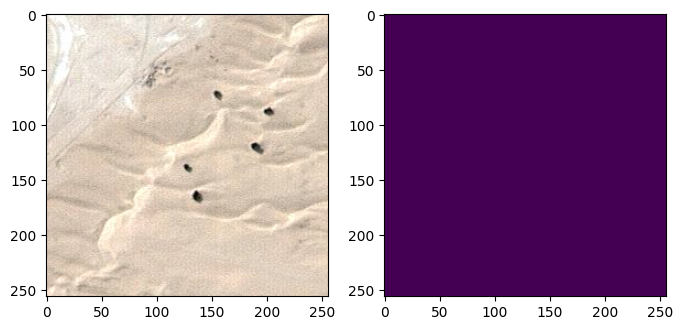

In [79]:
#random plots
random_image=random.randint(0,len(image_dataset))
plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(image_dataset[random_image])
plt.subplot(122)
#plt.imshow(mask_dataset[random_image])
plt.imshow(labels[random_image][:,:,0])

In [24]:
master_training_data=image_dataset

In [25]:
total_classes=len(np.unique( labels))

In [26]:
print(total_classes)

6


In [27]:
total_classes=len(np.unique(labels))

In [28]:
categorical_labels=to_categorical(labels,num_classes=total_classes)

In [29]:
categorical_labels.shape

(945, 256, 256, 6)

In [30]:
X_train,X_test,y_train,y_test=train_test_split(master_training_data,categorical_labels,test_size=0.15,random_state=100)

In [31]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(803, 256, 256, 3)
(803, 256, 256, 6)
(142, 256, 256, 3)
(142, 256, 256, 6)


In [32]:
image_height=X_train.shape[1]
image_width=X_train.shape[2]
image_channels=X_train.shape[3]
total_classes=y_train.shape[3]


In [33]:
print(image_height)
print(image_width)
print(image_channels)
print(total_classes)



256
256
3
6


In [34]:
from keras import backend as K

In [35]:

def jaccard_coef(y_true, y_pred):
  # Use tf.keras.layers.Flatten instead of K.flatten
  y_true_flatten = tf.keras.layers.Flatten()(y_true)
  y_pred_flatten = tf.keras.layers.Flatten()(y_pred)
  # Use tf.reduce_sum instead of K.sum
  intersection = tf.reduce_sum(y_true_flatten * y_pred_flatten)
  final_coeff_value = (intersection + 1.0) / (tf.reduce_sum(y_true_flatten) + tf.reduce_sum(y_pred_flatten) - intersection + 1.0)
  return final_coeff_value

In [36]:

#this model defines models which can therfore be used in determining the LULc of other models
def multi_unet_model(n_classes=5,image_height=256,image_width= 256,image_channels=1):
  input=Input((image_height,image_width,image_channels))
  input_tensor=input
  c1=Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(input_tensor)
  c1=Dropout(0.2)(c1)

  c1=Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c1)
  p1=MaxPooling2D((2,2))(c1)

  c2=Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p1)
  c2=Dropout(0.2)(c2)
  c2=Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c2)
  p2=MaxPooling2D((2,2))(c2)

  c3=Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p2)
  c3=Dropout(0.2)(c3)
  c3=Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c3)
  p3=MaxPooling2D((2,2))(c3)

  c4=Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p3)
  c4=Dropout(0.2)(c4)
  c4=Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c4)
  p4=MaxPooling2D((2,2))(c4)

  c5=Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p4)
  c5=Dropout(0.2)(c5)
  c5=Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c5)
  #u is for up sampling
  u6=Conv2DTranspose(128,(2,2),strides=(2,2),padding='same')(c5)
  u6=concatenate([u6,c4])
  c6=Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u6)
  c6=Dropout(0.2)(c6)
  c6=Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c6)

  u7=Conv2DTranspose(64,(2,2),strides=(2,2),padding='same')(c6)
  u7=concatenate([u7,c3])
  c7=Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u7)
  c7=Dropout(0.2)(c7)
  c7=Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c7)

  u8=Conv2DTranspose(32,(2,2),strides=(2,2),padding='same')(c7)
  u8=concatenate([u8,c2])
  c8=Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u8)
  c8=Dropout(0.2)(c8)
  c8=Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c8)

  u9=Conv2DTranspose(16,(2,2),strides=(2,2),padding='same')(c8)
  u9=concatenate([u9,c1],axis=3)
  c9=Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u9)
  c9=Dropout(0.2)(c9)
  c9=Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c9)

  outputs=Conv2D(n_classes,(1,1),activation='softmax')(c9)

  model=Model(inputs=[input],outputs=[outputs])
  return model




In [37]:
 #setting model metrics
metrics=["accuracy",jaccard_coef]


In [38]:
def get_deep_learning_model():
  model=multi_unet_model(n_classes=total_classes,
                         image_height=image_height,
                         image_width=image_width,
                         image_channels=image_channels
                         )
  return model

In [39]:
model=get_deep_learning_model()

In [40]:
#model.get_config()

In [41]:
#loss function
weights=[0.166,0.166,0.166,0.166,0.166,0.166]
weights=np.array(weights)

In [42]:
dice_loss=sm.losses.DiceLoss(weights)


In [43]:
focal_loss=sm.losses.CategoricalFocalLoss()

In [44]:
total_loss=dice_loss+(1*focal_loss)

In [45]:
tf.keras.backend.clear_session()

In [46]:
model.compile(optimizer='adam',loss=total_loss,metrics=metrics)

In [47]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [48]:
model_history=model.fit(X_train,y_train,
                        batch_size=16,
                        epochs=5,
                        verbose=1,
                        validation_data=(X_test,y_test),
                         )

Epoch 1/5
51/51 [==============================] - 530s 10s/step - loss: 0.7731 - accuracy: 0.5832 - jaccard_coef: 0.3444 - val_loss: 0.6828 - val_accuracy: 0.6950 - val_jaccard_coef: 0.4728
Epoch 2/5
51/51 [==============================] - 514s 10s/step - loss: 0.6405 - accuracy: 0.6813 - jaccard_coef: 0.5040 - val_loss: 0.6100 - val_accuracy: 0.6683 - val_jaccard_coef: 0.4954
Epoch 3/5
51/51 [==============================] - 510s 10s/step - loss: 0.5807 - accuracy: 0.7209 - jaccard_coef: 0.5271 - val_loss: 0.5072 - val_accuracy: 0.7647 - val_jaccard_coef: 0.5906
Epoch 4/5
51/51 [==============================] - 506s 10s/step - loss: 0.5042 - accuracy: 0.7415 - jaccard_coef: 0.5577 - val_loss: 0.4855 - val_accuracy: 0.7253 - val_jaccard_coef: 0.5486
Epoch 5/5
51/51 [==============================] - 503s 10s/step - loss: 0.4424 - accuracy: 0.6936 - jaccard_coef: 0.5068 - val_loss: 0.4180 - val_accuracy: 0.6801 - val_jaccard_coef: 0.5030


In [51]:
history_a=model_history
history_a.history

{'loss': [0.773063063621521,
  0.6405492424964905,
  0.5807288885116577,
  0.5041624903678894,
  0.4424031972885132],
 'accuracy': [0.5831872820854187,
  0.6812952160835266,
  0.7209071516990662,
  0.7414544820785522,
  0.69362872838974],
 'jaccard_coef': [0.3443586826324463,
  0.504043459892273,
  0.5271056890487671,
  0.557679295539856,
  0.5068050622940063],
 'val_loss': [0.6827796101570129,
  0.6099997758865356,
  0.5072430968284607,
  0.4855133295059204,
  0.41803178191185],
 'val_accuracy': [0.6949687600135803,
  0.6683216094970703,
  0.764681875705719,
  0.7252909541130066,
  0.6801028251647949],
 'val_jaccard_coef': [0.472811758518219,
  0.4954107701778412,
  0.5905576348304749,
  0.548595666885376,
  0.5030401349067688]}

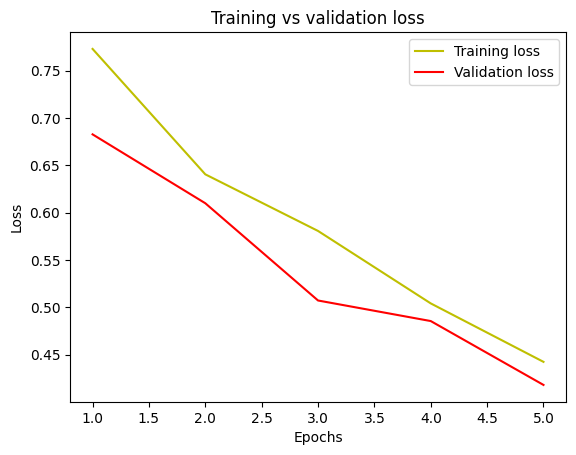

In [52]:
#plots
loss=history_a.history['loss']
val_loss=history_a.history['val_loss']
epochs=range(1,len(loss)+1)
plt.plot(epochs,loss,'y',label='Training loss')
plt.plot(epochs,val_loss,'r',label='Validation loss')
plt.title('Training vs validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

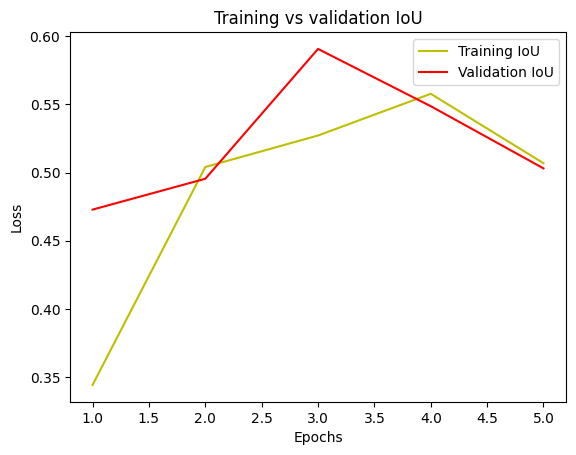

In [53]:
#plots for jacanda
jaccard_coef=history_a.history['jaccard_coef']
val_jaccard_coef=history_a.history['val_jaccard_coef']
epochs=range(1,len(jaccard_coef)+1)
plt.plot(epochs,jaccard_coef,'y',label='Training IoU')
plt.plot(epochs,val_jaccard_coef,'r',label='Validation IoU')
plt.title('Training vs validation IoU')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [54]:
model_history.params

{'verbose': 1, 'epochs': 5, 'steps': 51}

In [55]:
#performing predictions
y_predict=model.predict(X_test)

5/5 [==============================] - 15s 3s/step


In [56]:
y_predict

array([[[[5.43131074e-03, 2.13722154e-01, 3.76106165e-02,
          2.06199065e-02, 7.19914138e-01, 2.70188274e-03],
         [1.19746539e-04, 9.21527892e-02, 3.63754272e-03,
          1.68137637e-03, 9.02319133e-01, 8.94726982e-05],
         [3.92600959e-05, 6.79700002e-02, 1.62065565e-03,
          8.96756595e-04, 9.29443002e-01, 3.03779507e-05],
         ...,
         [1.14735414e-03, 1.38913706e-01, 7.77120888e-03,
          6.22521061e-03, 8.44346762e-01, 1.59580132e-03],
         [2.54641310e-03, 1.52379677e-01, 9.63681471e-03,
          9.86971613e-03, 8.21520030e-01, 4.04725643e-03],
         [7.73615949e-03, 2.80812711e-01, 3.23867574e-02,
          4.09675948e-02, 6.19323790e-01, 1.87729429e-02]],

        [[3.53584561e-04, 9.80428383e-02, 2.30575190e-03,
          4.82930150e-03, 8.93949389e-01, 5.19090914e-04],
         [1.74959052e-06, 4.50666957e-02, 4.68624603e-05,
          2.30600213e-04, 9.54647660e-01, 6.40203780e-06],
         [4.45581435e-07, 2.91435085e-02, 1.4557

In [58]:
y_predict_argmax=np.argmax(y_predict,axis=3)
y_predict_argmax

array([[[4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4],
        ...,
        [4, 4, 4, ..., 1, 1, 1],
        [4, 4, 4, ..., 1, 1, 1],
        [4, 4, 4, ..., 1, 1, 1]],

       [[0, 4, 0, ..., 4, 4, 4],
        [0, 0, 0, ..., 4, 4, 4],
        [0, 0, 0, ..., 4, 4, 4],
        ...,
        [4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4]],

       [[4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4],
        ...,
        [4, 4, 4, ..., 2, 2, 2],
        [4, 4, 4, ..., 2, 2, 2],
        [4, 4, 4, ..., 2, 2, 2]],

       ...,

       [[4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 1, 1, 4],
        ...,
        [1, 1, 1, ..., 4, 4, 4],
        [1, 1, 1, ..., 4, 4, 4],
        [1, 1, 1, ..., 4, 4, 4]],

       [[0, 4, 0, ..., 4, 4, 4],
        [0, 0, 0, ..., 4, 4, 4],
        [0, 0, 0, ..., 4, 4, 4],
        ...,
        [0, 4, 0, ..., 

In [59]:
y_test_argmax=np.argmax(y_test,axis=3)
y_test_argmax


array([[[3, 3, 3, ..., 1, 1, 1],
        [3, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3],
        ...,
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[2, 2, 2, ..., 1, 1, 1],
        [2, 2, 2, ..., 1, 1, 1],
        [2, 2, 2, ..., 1, 1, 1],
        ...,
        [2, 2, 2, ..., 0, 0, 0],
        [2, 2, 2, ..., 0, 0, 0],
        [2, 2, 1, ..., 0, 0, 0]],

       ...,

       [[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [70]:
#comparison of predictions
test_image_number=random.randint(0,len(X_test))
test_image=X_test[test_image_number]
ground_truth=y_test_argmax[test_image_number]
test_image_input=np.expand_dims(test_image,0)
ground_truth_input=np.expand_dims(ground_truth,0)

prediction=model.predict(test_image_input)
predicted_image=np.argmax(prediction,axis=3)[0,:,:]


1/1 [==============================] - 0s 324ms/step


In [71]:
predicted_image

array([[4, 4, 4, ..., 4, 4, 4],
       [4, 4, 4, ..., 4, 4, 4],
       [4, 4, 4, ..., 4, 4, 4],
       ...,
       [1, 1, 1, ..., 4, 4, 4],
       [1, 1, 1, ..., 4, 4, 4],
       [1, 1, 1, ..., 4, 4, 4]])

In [ ]:
#performing plots to compare the imags
plt.figure(figsize=(12,8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_image)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_image)

In [74]:
#saving and exporting model to disk
model.save('image_segmentation_model.h5')

In [75]:
!ls -lah


total 23M
drwxr-xr-x 1 root root 4.0K Feb 19 16:15 .
drwxr-xr-x 1 root root 4.0K Feb 19 14:57 ..
drwxr-xr-x 4 root root 4.0K Feb 14 14:19 .config
drwx------ 6 root root 4.0K Feb 19 15:04 drive
-rw-r--r-- 1 root root  23M Feb 19 16:15 image_segmentation_model.h5
drwxr-xr-x 1 root root 4.0K Feb 14 14:20 sample_data
